In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv
import utils.preproc as pre

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [36]:
base_model = torch.load('SavedModels/base_model.pth').to(device)
gmm_model = torch.load('SavedModels/gmm_model.pth').to(device)

In [4]:
def test_metrics(model, device, in_loader, out_loader, thresholds=torch.linspace(.1, 1., 1000).to(device)):
    with torch.no_grad():
        model.eval()
        conf_in = []
        conf_out = []
        count = 0.
        for ((batch_idx, (data_in, _)), (_, (data_out, _))) in zip(enumerate(in_loader),enumerate(out_loader)):
            count += 1
            data_in = data_in.to(device)
            data_out = data_out.to(device)

            output_in = model(data_in).max(1)[0].exp()
            output_out = model(data_out).max(1)[0].exp()

            conf_in.append(output_in)
            conf_out.append(output_out)
        conf_in = torch.cat(conf_in)
        conf_out = torch.cat(conf_out)
        
        tp = (conf_in[:,None] > thresholds[None,:]).sum(0).float()/(count*in_loader.batch_size)
        fp = (conf_out[:,None] > thresholds[None,:]).sum(0).float()/(count*out_loader.batch_size)
        
        mmc = conf_out.mean().item()
        auroc = -np.trapz(tp.cpu().numpy(), x=fp.cpu().numpy())
        fp95 = ((conf_out > 0.95).sum().float()/(count*out_loader.batch_size)).item()
        return mmc, auroc, fp95

In [5]:
def evaluate_model(model, device, base_loader, loaders):
    metrics = []
    mmc, _, _ = test_metrics(model, device, base_loader, base_loader)
    metrics.append(['MNIST', mmc, '-', '-'])
    for (name, data_loader) in loaders:
        mmc, auroc, fp95 = test_metrics(model, device, base_loader, data_loader)
        metrics.append([name, mmc, auroc, fp95])
    df = pd.DataFrame(metrics, columns = ['DataSet', 'MMC', 'AUROC', 'FPR@95'])
    return df.set_index('DataSet')

In [160]:
loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', Adv_noise_loader)]
)

In [161]:
df = evaluate_model(base_model, device, dl.MNIST_test_loader, loaders)

In [162]:
df

,MMC,AUROC,FPR@95
DataSet,,,
MNIST,0.992019,-,-
FMNIST,0.686990,0.984332,0.1078
EMNIST,0.854618,0.869306,0.4906
GrayCIFAR10,0.632773,0.989706,0.0572
Noise,0.383731,0.999387,0
Adv. Noise,0.839936,0.898021,0.4257


In [167]:
adv_noise_transform = transforms.Compose([dl.noise_transform,
                                         pre.AdversarialNoise(base_model, device)])

test_batch_size = 10
Adv_noise_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=adv_noise_transform),
        batch_size=test_batch_size, shuffle=False)

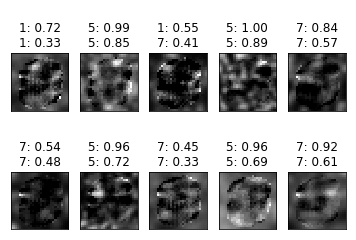

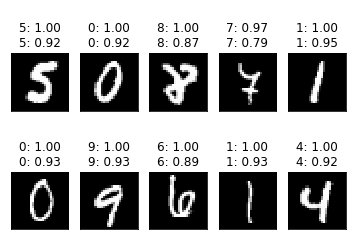

In [210]:
data = enumerate(Adv_noise_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = enumerate(adv_sample_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

In [348]:
lr = .0001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum, weight_decay=0.005)
for epoch in range(1):
    optimizer_base.param_groups[0]['lr'] *= .8
    tt.train_adv(base_model, device, dl.train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.359271
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.532630
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.532842
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.532842
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.532846
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.532845


In [204]:
reload(adv)

<module 'adversarial' from '/home/alexm/project/notebooks/gmm-robust/adversarial.py'>

In [205]:
new_data = []
for batch_idx, (data, target) in enumerate(dl.MNIST_test_loader):
    data, target = data.to(device), target.to(device)
    
    new_data.append(adv.generate_adv_sample(base_model, 3., data, target,
                        device=device, 
                        batch_size=10, norm=2, 
                        num_of_it=40, alpha=0.01).detach().cpu()
                   )
    if batch_idx % 100 == 0:
        print(batch_idx)

0
100
200
300
400
500
600
700
800
900


In [207]:
new_data= torch.cat(new_data, 0)

In [208]:
new_data.shape

torch.Size([10000, 1, 28, 28])

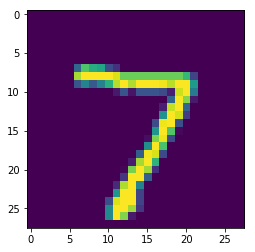

In [209]:
plt.imshow(new_data[0][0])

In [201]:
import torch.utils.data as data_utils

adv_sample_set = data_utils.TensorDataset(new_data, torch.zeros(10000,10))
adv_sample_loader = data_utils.DataLoader(adv_sample_set, batch_size=10, shuffle=True)

In [261]:
def generate_adv_sample(model, epsilon, seed_images, seed_labels,
                        device=torch.device('cpu'), 
                        batch_size=10, norm=2, 
                        num_of_it=40, alpha=0.01):
    
    image = seed_images.to(device).requires_grad_()
    perturbed_image = image
    for _ in range(num_of_it):
        with torch.enable_grad():
            y = model(perturbed_image)
            loss = F.nll_loss(y, seed_labels)
        
        loss.backward()

        with torch.no_grad():
            perturbed_image += alpha*image.grad

            delta = perturbed_image-image
            delta /= delta.view((batch_size,784)).norm(p=norm, dim=1)[:,None,None,None]
            delta *= epsilon
            perturbed_image = image + delta
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            perturbed_image = perturbed_image.detach()
    return perturbed_image

In [262]:
(data, target) = enumerate(dl.MNIST_test_loader).__next__()[1]

In [272]:
a = generate_adv_sample(base_model, .4, data.to(device), target.to(device),
                        device=device, 
                        batch_size=10, norm=20, 
                        num_of_it=4000, alpha=.1).detach().cpu()

In [273]:
(data-a).abs().sum()

tensor(1987.2286)

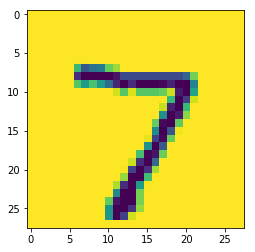

In [274]:
plt.imshow(a[0][0]-data[0][0])


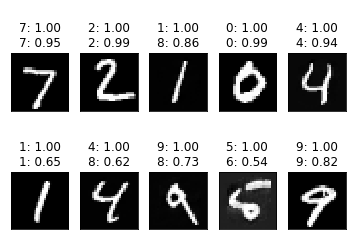

In [275]:
#data = enumerate(adv_sample_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = base_model(a.to(device))

plotting.plot_samples([y_base, y], a.detach().cpu())

In [367]:
def gen_adv_noise(model, device, seed, epsilon=0.1, steps=40, step_size=10000.):
    
    with torch.no_grad():
        batch_size = seed.shape[0]
        alpha = step_size * torch.ones(batch_size,1,1,1, device=device)

        orig_data = seed.to(device)
        prev_data = seed.to(device)
        data = seed.to(device).requires_grad_()

        prev_losses = -100000.*torch.ones(batch_size, device=device)
        prev_grad = torch.zeros_like(seed, device=device)
    for _ in range(steps):
        with torch.enable_grad():
            y = model(data)
            losses = y.max(1)[0]
            losses.sum().backward()
            
        with torch.no_grad():
            grad = data.grad
            regret_index = losses<prev_losses
            alpha[regret_index] /= 2.
            data[regret_index] = prev_data[regret_index]
            grad[regret_index] = prev_grad[regret_index]
            
            prev_losses=losses
            prev_data = data
            prev_grad = grad
            

            data += alpha*grad
            delta = torch.clamp(data-orig_data, -epsilon, epsilon)
            data = torch.clamp(orig_data + delta, 0, 1).requires_grad_()
    return data

In [363]:
a,b,c = gen_adv_noise(base_model, device, torch.rand(10,1,28,28))

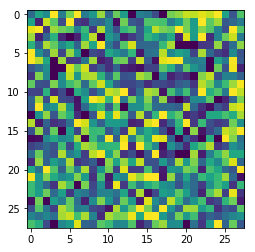

In [362]:
plt.imshow((a.cpu())[0][0].detach())

In [366]:
base_model(a.to(device)).exp().max(1)

(tensor([0.9998, 0.9999, 0.9997, 0.9997, 0.9997, 0.9997, 0.9988, 0.9996, 0.9998,
         0.9999], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'))

In [355]:
b

tensor([[[[10000.0000]]],


        [[[10000.0000]]],


        [[[ 1250.0000]]],


        [[[ 5000.0000]]],


        [[[ 2500.0000]]],


        [[[10000.0000]]],


        [[[ 2500.0000]]],


        [[[   78.1250]]],


        [[[10000.0000]]],


        [[[ 5000.0000]]]], device='cuda:0')

In [330]:
diff.abs().max()

tensor(0.0185, grad_fn=<MaxBackward1>)

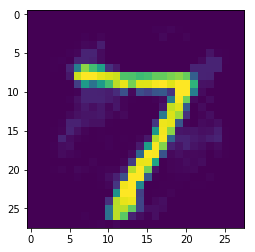

In [359]:
plt.imshow(a.detach().cpu()[0][0])

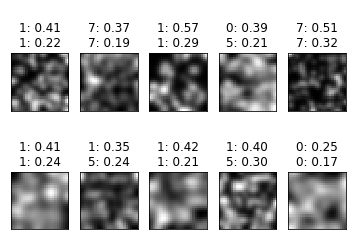

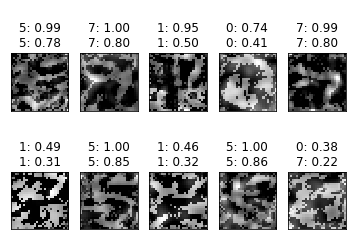

In [369]:
data = enumerate(dl.Noise_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = gen_adv_noise(base_model, device, data)

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())